In [1]:
import pandas as pd
import numpy as np

import jax.numpy as jnp
import jax
from jax import config
config.update("jax_enable_x64", True)

import os, sys
sys.path.insert(0, "/home/storage/hans/jax_reco/lib")

from geo import closest_point_on_track, closest_distance_dom_track
from geo import __c

ModuleNotFoundError: No module named 'geo'

In [2]:
bp = '/home/storage2/hans/i3files/21217'

# 1 TeV to 10 TeV muons (at detector boundary)
df_meta = pd.read_feather(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'))
df_pulses = pd.read_feather(os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'))
geo = pd.read_csv('/home/storage/hans/jax_reco/detector_geometry.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/home/storage/hans/jax_reco/detector_geometry.csv'

In [3]:
def get_event_data(meta: pd.DataFrame, 
                   data: pd.DataFrame, 
                   geo: pd.DataFrame, 
                   event_index: int = 0) -> np.ndarray:
    
    ev_idx = event_index
    event_meta = meta.iloc[ev_idx]
    event_data = (data.iloc[int(event_meta.idx_start): int(event_meta.idx_end + 1)]).copy(deep=True)
    return event_meta, event_data

In [4]:
meta, pulses = get_event_data(df_meta, df_pulses, geo, event_index=7)

In [5]:
meta

event_id                   2.121702e+09
idx_start                  9.870000e+02
idx_end                    1.067000e+03
n_channel_HLC              3.000000e+01
neutrino_energy            2.231877e+03
muon_energy                1.245381e+03
muon_energy_at_detector    1.090588e+03
muon_energy_lost           7.116959e+02
q_tot                      7.367500e+01
n_channel                  4.000000e+01
muon_zenith                2.044366e+00
muon_azimuth               2.300903e+00
muon_time                  7.532289e+03
muon_pos_x                -4.993546e+02
muon_pos_y                 9.034477e+02
muon_pos_z                -3.466690e+02
spline_mpe_zenith          2.048402e+00
spline_mpe_azimuth         2.302654e+00
spline_mpe_time            1.133257e+04
spline_mpe_pos_x           1.764334e+02
spline_mpe_pos_y           1.476970e+02
spline_mpe_pos_z           1.730323e+02
Name: 7, dtype: float64

In [6]:
print(pulses)

          event_id  sensor_id     time  charge  is_HLC
987   2.121702e+09     1153.0  13934.0   1.125     0.0
988   2.121702e+09     1203.0  13659.0   1.325     1.0
989   2.121702e+09     1205.0  13240.0   0.575     1.0
990   2.121702e+09     1205.0  13595.0   1.125     1.0
991   2.121702e+09     1207.0  13265.0   0.975     1.0
...            ...        ...      ...     ...     ...
1063  2.121702e+09     4229.0  10480.0   0.475     1.0
1064  2.121702e+09     4271.0  11955.0   0.525     0.0
1065  2.121702e+09     4588.0  10256.0   1.675     0.0
1066  2.121702e+09     4591.0  10048.0   0.525     1.0
1067  2.121702e+09     4592.0   9861.0   0.875     1.0

[81 rows x 5 columns]


In [7]:
print(geo)

      sensor_id       x       y       z
0             0 -256.14 -521.08  496.03
1             1 -256.14 -521.08  479.01
2             2 -256.14 -521.08  461.99
3             3 -256.14 -521.08  444.97
4             4 -256.14 -521.08  427.95
...         ...     ...     ...     ...
5155       5155  -10.97    6.72 -472.39
5156       5156  -10.97    6.72 -479.39
5157       5157  -10.97    6.72 -486.40
5158       5158  -10.97    6.72 -493.41
5159       5159  -10.97    6.72 -500.73

[5160 rows x 4 columns]


In [8]:
def get_loc_highest_charge_dom(pulses: pd.DataFrame, geo: pd.DataFrame):
    qtot_per_dom = pulses[['sensor_id', 'charge']].groupby(by=['sensor_id'], as_index=False).sum()
    sensor_id = qtot_per_dom.loc[qtot_per_dom['charge'].idxmax()]['sensor_id']
    return geo.iloc[[sensor_id]][['x', 'y', 'z']].to_numpy().squeeze()

def get_qtot_per_dom_with_coords(pulses: pd.DataFrame, geo: pd.DataFrame):
    df = pulses[['sensor_id', 'charge']].groupby(by=['sensor_id'], as_index=False).sum()
    df = df.merge(geo.iloc[df['sensor_id']], on='sensor_id', how='outer')
    return df
    
def get_xyz_from_zenith_azimuth(x):
    zenith, azimuth = x
    x = np.zeros(3)
    x[0] = np.sin(zenith) * np.cos(azimuth)
    x[1] = np.sin(zenith) * np.sin(azimuth)
    x[2] = np.cos(zenith)
    # flip vector by 180deg
    x *= -1.0
    return x

def get_min_t_per_dom_with_coords(pulses: pd.DataFrame, geo: pd.DataFrame):
    df = pulses[['sensor_id', 'time']].groupby(by=['sensor_id'], as_index=False).min()
    df = df.merge(geo.iloc[df['sensor_id']], on='sensor_id', how='outer')
    return df

def get_per_dom_info(pulses: pd.DataFrame, geo: pd.DataFrame):
    df_qtot = pulses[['sensor_id', 'charge']].groupby(by=['sensor_id'], as_index=False).sum()
    df_tmin = pulses[['sensor_id', 'time']].groupby(by=['sensor_id'], as_index=False).min()
    df = df_qtot.merge(geo.iloc[df_qtot['sensor_id']], on='sensor_id', how='outer')
    df['time'] = df_tmin['time'].values
    return df
    

In [9]:
dom_info = get_qtot_per_dom_with_coords(pulses, geo)
dom_info_t = get_min_t_per_dom_with_coords(pulses, geo)
dom_info_all = get_per_dom_info(pulses, geo)

In [10]:
print(dom_info)

    sensor_id  charge       x       y       z
0      1153.0   1.125  326.85 -209.07  277.15
1      1203.0   1.325  443.66 -194.04  465.61
2      1205.0   1.700  443.75 -194.01  431.57
3      1207.0   0.975  443.85 -194.02  397.53
4      1209.0   0.875  443.93 -194.08  363.49
5      1689.0   0.875  371.56  -92.18  349.40
6      1690.0   2.200  371.56  -92.18  331.38
7      1691.0   1.725  371.56  -92.18  315.36
8      1693.0   0.700  371.56  -92.18  281.31
9      2232.0   2.775  292.90    5.20  287.16
10     2233.0   7.850  292.90    5.20  270.13
11     2234.0   1.800  292.90    5.20  253.11
12     2235.0   2.100  292.90    5.20  236.09
13     2723.0   0.375   90.49   82.35  110.19
14     2775.0   1.475  195.03  125.59  246.52
15     2777.0   0.525  195.03  125.59  212.48
16     2778.0   8.300  195.03  125.59  195.46
17     2779.0   3.050  195.03  125.59  178.44
18     2780.0   2.600  195.03  125.59  161.42
19     2834.0   0.425  330.03  127.20  262.58
20     3316.0   0.225  132.03  202

In [11]:
print(dom_info_t['time'])

0     13934.0
1     13659.0
2     13240.0
3     13265.0
4     13080.0
5     12601.0
6     12546.0
7     12590.0
8     12625.0
9     12127.0
10    12053.0
11    12065.0
12    12112.0
13    11913.0
14    11853.0
15    11688.0
16    11471.0
17    11462.0
18    11481.0
19    12870.0
20    11641.0
21    11194.0
22    11114.0
23    11078.0
24    11349.0
25    10924.0
26    10807.0
27    10656.0
28    10642.0
29    10737.0
30    12468.0
31    11209.0
32     9647.0
33    10680.0
34    10373.0
35    10205.0
36    11955.0
37    10256.0
38    10048.0
39     9861.0
Name: time, dtype: float64


In [12]:
print(dom_info_all.columns.values)

['sensor_id' 'charge' 'x' 'y' 'z' 'time']


In [13]:
dom_info['charge'] = np.round(dom_info['charge']+0.5)

In [14]:
print(dom_info)

    sensor_id  charge       x       y       z
0      1153.0     2.0  326.85 -209.07  277.15
1      1203.0     2.0  443.66 -194.04  465.61
2      1205.0     2.0  443.75 -194.01  431.57
3      1207.0     1.0  443.85 -194.02  397.53
4      1209.0     1.0  443.93 -194.08  363.49
5      1689.0     1.0  371.56  -92.18  349.40
6      1690.0     3.0  371.56  -92.18  331.38
7      1691.0     2.0  371.56  -92.18  315.36
8      1693.0     1.0  371.56  -92.18  281.31
9      2232.0     3.0  292.90    5.20  287.16
10     2233.0     8.0  292.90    5.20  270.13
11     2234.0     2.0  292.90    5.20  253.11
12     2235.0     3.0  292.90    5.20  236.09
13     2723.0     1.0   90.49   82.35  110.19
14     2775.0     2.0  195.03  125.59  246.52
15     2777.0     1.0  195.03  125.59  212.48
16     2778.0     9.0  195.03  125.59  195.46
17     2779.0     4.0  195.03  125.59  178.44
18     2780.0     3.0  195.03  125.59  161.42
19     2834.0     1.0  330.03  127.20  262.58
20     3316.0     1.0  132.03  202

In [15]:
qmax_sensor_pos = get_loc_highest_charge_dom(pulses, geo)
print(qmax_sensor_pos)
track_pos = np.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
spline_mpe_pos = np.array([meta['spline_mpe_pos_x'], meta['spline_mpe_pos_y'], meta['spline_mpe_pos_z']])
print(track_pos)
source_dir = np.array([meta['muon_zenith'], meta['muon_azimuth']])
track_dir_xyz = get_xyz_from_zenith_azimuth(source_dir)

[ 54.26 292.97  82.02]
[-499.35459338  903.4477253  -346.66904009]


In [16]:
closest_approach_point = closest_point_on_track(qmax_sensor_pos, track_pos, track_dir_xyz)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [17]:
print(closest_approach_point)

[ 52.00229615 287.48142386  76.97812184]


In [18]:
muon_travel_time = np.linalg.norm(closest_approach_point - track_pos) / __c

In [19]:
print(muon_travel_time)

3098.53184291986


In [20]:
print(meta['muon_time']+muon_travel_time)

10630.82061270145


In [21]:
print(meta['muon_time'])

7532.2887697815895


In [22]:
print(meta['spline_mpe_time'])

11332.570856332288


In [23]:
pos_spline_mpe = np.array([meta['spline_mpe_pos_x'], 
                           meta['spline_mpe_pos_y'], 
                           meta['spline_mpe_pos_z']])

In [24]:
print(np.linalg.norm(pos_spline_mpe - closest_approach_point))

210.3548780997447


In [25]:
print(closest_distance_dom_track(pos_spline_mpe, track_pos, track_dir_xyz))

0.5319500404689697


In [26]:
from geo import cherenkov_cylinder_coordinates_v, convert_spherical_to_cartesian_direction
from geo import closest_point_on_track_v

In [27]:
track_dir_xyz_ = -1 * convert_spherical_to_cartesian_direction(source_dir)

In [28]:
print(track_dir_xyz, track_dir_xyz_)

[ 0.5935484  -0.66310192  0.45606594] [ 0.5935484  -0.66310192  0.45606594]


In [29]:
charges = dom_info['charge'].values
dom_positions = dom_info[['x', 'y', 'z']].to_numpy()

In [30]:
geo_time, closest_approach_dist, closest_approach_z = cherenkov_cylinder_coordinates_v(dom_positions, track_pos, track_dir_xyz)

In [31]:
print(geo_time)

[5470.93864756 5732.22468921 5606.09412652 5511.97860299 5492.59161619
 5049.76394351 5001.85767969 4993.55191562 5017.88711454 4577.33249526
 4520.32683559 4512.00472666 4525.96066554 4027.10812841 4149.77050698
 4010.12300141 3940.54096602 3918.35581744 3936.21007892 4586.63079479
 3919.79397163 3640.83838692 3572.22491173 3545.41541176 3562.17304025
 3325.36944461 3186.797675   3121.13721693 3104.23943526 3137.36457538
 4054.12948663 2773.70787388 3159.18862633 2951.45040846 2690.71108608
 2657.15331817 4066.68737083 2477.63386526 2282.32409149 2230.50211643]


In [32]:
print(closest_approach_dist)

[146.55356861  69.58206962  43.93197727  29.27342805  40.33361143
  22.17191626  15.11231579  20.64654405  46.87407966  19.89158836
   9.17852076  15.23118056  28.95839206 119.92624575  52.38343708
  22.11542579   7.06468923   8.34167858  23.41182096 103.61179658
  83.54403454  23.12494078   8.40786296   8.09181219  22.78417611
  51.38453843  21.48710679   7.78731212  10.89098403  40.14132074
 172.4767896  106.93242573 117.65762167  72.85261884  18.71407529
  16.07331763 269.66843168  72.27421217  31.7506768   22.81809307]


In [33]:
print(closest_approach_z)

[343.17979177 409.45353896 402.38864065 395.33854604 388.2981584
 334.96072161 331.21263122 327.8805331  320.79826463 271.27251564
 267.73034142 264.19024717 260.65015291 156.3400537  199.91829016
 192.83810165 189.2980074  185.75791314 182.21781889 239.31593769
 156.10732407 141.94694705 138.4068528  134.86675854 131.32666429
  87.59840461  80.5182161   76.97812184  73.43594763  66.35575912
 139.17765672  -9.87411167  38.57404792  27.95376515  13.79130817
  10.25121391 102.32004025 -36.59929719 -47.21957996 -50.75967421]


In [34]:
print(geo_time)

[5470.93864756 5732.22468921 5606.09412652 5511.97860299 5492.59161619
 5049.76394351 5001.85767969 4993.55191562 5017.88711454 4577.33249526
 4520.32683559 4512.00472666 4525.96066554 4027.10812841 4149.77050698
 4010.12300141 3940.54096602 3918.35581744 3936.21007892 4586.63079479
 3919.79397163 3640.83838692 3572.22491173 3545.41541176 3562.17304025
 3325.36944461 3186.797675   3121.13721693 3104.23943526 3137.36457538
 4054.12948663 2773.70787388 3159.18862633 2951.45040846 2690.71108608
 2657.15331817 4066.68737083 2477.63386526 2282.32409149 2230.50211643]


In [35]:
closest_point = closest_point_on_track_v(dom_positions, track_pos, track_dir_xyz)

In [36]:
print(closest_point)

[[ 398.45127046  -99.56532823  343.17979177]
 [ 484.70344064 -195.92474853  409.45353896]
 [ 475.50880721 -185.65266442  402.38864065]
 [ 466.33344011 -175.4021043   395.33854604]
 [ 457.17070616 -165.16565774  388.2981584 ]
 [ 387.75453656  -87.61512366  334.96072161]
 [ 382.8765729   -82.16554773  331.21263122]
 [ 378.54000365  -77.3208082   327.8805331 ]
 [ 369.32276377  -67.02346855  320.79826463]
 [ 304.86732687    4.98502146  271.27251564]
 [ 300.25735345   10.13520337  267.73034142]
 [ 295.650087     15.2823611   264.19024717]
 [ 291.04282054   20.42951884  260.65015291]
 [ 155.28812415  172.09229811  156.3400537 ]
 [ 212.00315275  108.73125726  199.91829016]
 [ 202.78861984  119.02557273  192.83810165]
 [ 198.18135339  124.17273046  189.2980074 ]
 [ 193.57408693  129.31988819  185.75791314]
 [ 188.96682048  134.46704592  182.21781889]
 [ 263.27734115   51.44862819  239.31593769]
 [ 154.98523746  172.43067784  156.10732407]
 [ 136.55617165  193.01930876  141.94694705]
 [ 131.948

In [37]:
muon_travel_times = jax.numpy.linalg.norm(track_pos - closest_point, axis=1)/__c

In [38]:
print(muon_travel_times)

[5045.51609074 5530.23860146 5478.56632713 5427.00232623 5375.50932154
 4985.40226746 4957.98894224 4933.61816143 4881.81884268 4519.59026175
 4493.68299602 4467.790943   4441.89888998 3678.98061038 3997.70941458
 3945.92530855 3920.03325553 3894.14120251 3868.2491495  4285.86162326
 3677.27843878 3573.71022671 3547.8181737  3521.92612068 3496.03406767
 3176.20800197 3124.42389594 3098.53184292 3072.62457718 3020.84047115
 3553.45579086 2463.29942465 2817.64657646 2739.97041741 2636.38699263
 2610.49493961 3283.88122844 2267.83290016 2190.15674112 2164.2646881 ]


In [39]:
print(dom_info_t['time'].values - (geo_time + meta['muon_time']))

[ 9.30772583e+02  3.94486541e+02  1.01617104e+02  2.20732627e+02
  5.51196140e+01  1.89472867e+01  1.18535505e+01  6.41593146e+01
  7.48241157e+01  1.73787350e+01  3.84394632e-01  2.07065036e+01
  5.37505647e+01  3.53603102e+02  1.70940723e+02  1.45588229e+02
 -1.82973580e+00  1.13554128e+01  1.25011513e+01  7.51080435e+02
  1.88917259e+02  2.08728433e+01  9.48631849e+00  2.95818458e-01
  2.54538190e+02  6.63417856e+01  8.79135552e+01  2.57401329e+00
  5.47179496e+00  6.73466548e+01  8.81581744e+02  9.03003356e+02
 -1.04447740e+03  1.96260822e+02  1.50000144e+02  1.55579120e+01
  3.56023859e+02  2.46077365e+02  2.33387139e+02  9.82091138e+01]


In [40]:
print(closest_approach_dist)

[146.55356861  69.58206962  43.93197727  29.27342805  40.33361143
  22.17191626  15.11231579  20.64654405  46.87407966  19.89158836
   9.17852076  15.23118056  28.95839206 119.92624575  52.38343708
  22.11542579   7.06468923   8.34167858  23.41182096 103.61179658
  83.54403454  23.12494078   8.40786296   8.09181219  22.78417611
  51.38453843  21.48710679   7.78731212  10.89098403  40.14132074
 172.4767896  106.93242573 117.65762167  72.85261884  18.71407529
  16.07331763 269.66843168  72.27421217  31.7506768   22.81809307]


Text(0, 0.5, 'delay time [ns]')

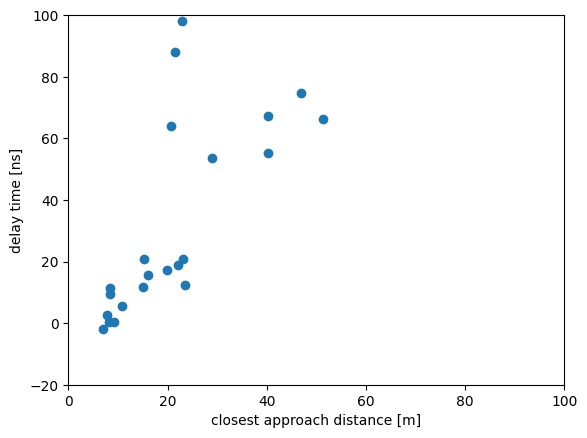

In [41]:
import matplotlib.pyplot as plt
plt.scatter(closest_approach_dist, dom_info_t['time'].values - (geo_time + meta['muon_time']))
plt.xlim([0, 100])
plt.ylim([-20, 100])
plt.xlabel('closest approach distance [m]')
plt.ylabel('delay time [ns]')

In [42]:
print(np.min(dom_info_t['time'].values - (geo_time + meta['muon_time'])))

-1044.4773961128394


In [43]:
closest_point = closest_point_on_track(spline_mpe_pos, track_pos, track_dir_xyz)

In [44]:
dt = np.linalg.norm(closest_point-track_pos)/__c

In [45]:
print(meta['muon_time']+dt, meta['spline_mpe_time'])

11332.486714972743 11332.570856332288


In [46]:
from network import TriplePandleNet
from trafos import transform_network_outputs_v, transform_network_inputs_v

In [47]:
from geo import rho_dom_relative_to_track_v

In [48]:
track_dir_xyz = jnp.array(track_dir_xyz)
track_pos = jnp.array(track_pos)
dom_positions = jnp.array(dom_positions)
closest_approach_rho = rho_dom_relative_to_track_v(dom_positions, track_pos, track_dir_xyz)

In [49]:
zenith = jnp.rad2deg(jnp.ones_like(closest_approach_dist) * meta['muon_zenith'])
azimuth = jnp.rad2deg(jnp.ones_like(closest_approach_dist) * meta['muon_azimuth'])
print(zenith.shape)
print(azimuth.shape)
print(closest_approach_dist.shape)
print(closest_approach_rho.shape)
print(closest_approach_z.shape)
x = jnp.column_stack([closest_approach_dist, closest_approach_rho, closest_approach_z, zenith, azimuth])
print(x.shape)

(40,)
(40,)
(40,)
(40,)
(40,)
(40, 5)


In [50]:
y = transform_network_inputs_v(x)

In [51]:
print(y.shape)

(40, 7)


In [52]:
net = TriplePandleNet('../../data/network/')

In [53]:
y_pred = net.eval_on_batch(y)

In [54]:
logits, a, b = transform_network_outputs_v(y_pred)

In [55]:
mode = (a-1) / b
print(mode)

[[8.58961030e+02 5.31361164e+02 1.27495849e+03]
 [3.25851633e+02 1.74009974e+02 5.62951891e+02]
 [1.94373902e+02 9.22354662e+01 3.80004814e+02]
 [1.11325351e+02 4.59747371e+01 2.16389650e+02]
 [1.84806984e+02 8.39341855e+01 3.57473115e+02]
 [5.00647812e+01 2.11093680e+01 1.10419599e+02]
 [3.14464618e+01 1.25865795e+01 5.88879688e+01]
 [4.79675923e+01 2.00873325e+01 1.04482975e+02]
 [1.88428559e+02 8.93825686e+01 3.41824348e+02]
 [3.11798297e+01 1.26242119e+01 4.68799842e+01]
 [8.21740022e+00 3.39150886e+00 1.13408128e-01]
 [1.96244598e+01 7.91457163e+00 2.14091713e+00]
 [5.97105860e+01 2.59131086e+01 1.36217514e+02]
 [5.25600161e+02 2.80036969e+02 8.48645541e+02]
 [2.36406954e+02 1.09752161e+02 4.56175658e+02]
 [6.09602374e+01 2.51246895e+01 1.18938648e+02]
 [8.55879819e+00 3.27845894e+00 9.74207769e-02]
 [1.08295344e+01 4.23694511e+00 1.83664678e-01]
 [6.09587455e+01 2.51315031e+01 1.20157155e+02]
 [5.33005141e+02 2.85075906e+02 8.32627293e+02]
 [3.59124124e+02 1.82072772e+02 6.312359

In [56]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

from plotting_tools import adjust_plot_1d

2024-05-20 10:52:37.337065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[ 9.30772583e+02  3.94486541e+02  1.01617104e+02  2.20732627e+02
  5.51196140e+01  1.89472867e+01  1.18535505e+01  6.41593146e+01
  7.48241157e+01  1.73787350e+01  3.84394632e-01  2.07065036e+01
  5.37505647e+01  3.53603102e+02  1.70940723e+02  1.45588229e+02
 -1.82973580e+00  1.13554128e+01  1.25011513e+01  7.51080435e+02
  1.88917259e+02  2.08728433e+01  9.48631849e+00  2.95818458e-01
  2.54538190e+02  6.63417856e+01  8.79135552e+01  2.57401329e+00
  5.47179496e+00  6.73466548e+01  8.81581744e+02  9.03003356e+02
 -1.04447740e+03  1.96260822e+02  1.50000144e+02  1.55579120e+01
  3.56023859e+02  2.46077365e+02  2.33387139e+02  9.82091138e+01]


/home/storage/hans/jax_reco/python/plotting_tools.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


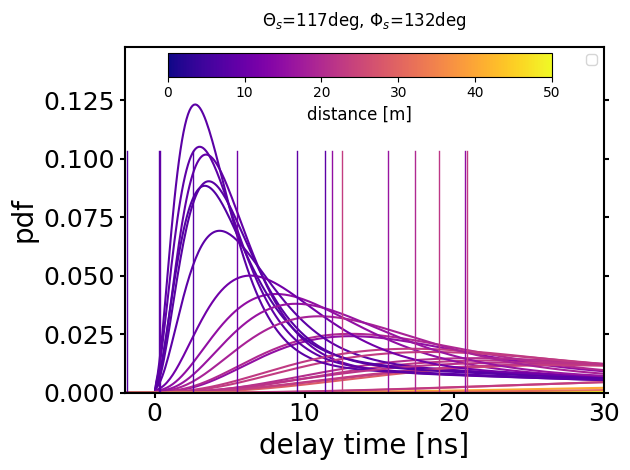

In [57]:
n = logits.shape[0]
cmap = plt.cm.plasma
c_map = plt.cm.ScalarMappable(norm=Normalize(vmin=0, vmax=50), cmap=cmap)

dists = np.array(closest_approach_dist)
cols = [c_map.to_rgba(dist) for dist in dists]

# create a batch of mixture distributions
gm = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(
              logits=logits
              ),
          components_distribution=tfd.Gamma(
            concentration=a,    
            rate=b,
            force_probs_to_zero_outside_support=True
              )
    )

# vectorized plotting
xvals = np.linspace(-10, 1000, 10000)
xvals = xvals.reshape(10000, 1) # allow broadcasting along batch dimension
#xvals = np.repeat(xvals[np.newaxis,:], 20, axis=0).T

yvals = gm.prob(xvals)

fig, ax = plt.subplots()
ax.set_prop_cycle(color=cols)
plt.plot(xvals, yvals)

delay_times = dom_info_all['time'].values - (geo_time + meta['muon_time'])
print(delay_times)
for dt, col in zip(delay_times, cols):
    plt.axvline(float(dt), ymax=0.7, linewidth=1, color=col)

plot_args = {'xlim':[-2, 30],
                 'ylim':[0.0, 1.2 * np.amax(yvals)],
                 'xlabel':'delay time [ns]',
                 'ylabel':'pdf'}

zenith = np.rad2deg(meta['muon_zenith'])
azimuth = np.rad2deg(meta['muon_azimuth'])
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"$\\Theta_s$={zenith:.0f}deg, $\\Phi_s$={azimuth:.0f}deg", pad=15)
plt.tight_layout()
cax = fig.add_axes([0.27, 0.83, 0.6, 0.05])
cb = fig.colorbar(c_map, cax=cax, orientation='horizontal')
cb.set_label('distance [m]',fontsize=12)
plt.show()

In [58]:
print(np.sort(dists))

[  7.06468923   7.78731212   8.09181219   8.34167858   8.40786296
   9.17852076  10.89098403  15.11231579  15.23118056  16.07331763
  18.71407529  19.89158836  20.64654405  21.48710679  22.11542579
  22.17191626  22.78417611  22.81809307  23.12494078  23.41182096
  28.95839206  29.27342805  31.7506768   40.14132074  40.33361143
  43.93197727  46.87407966  51.38453843  52.38343708  69.58206962
  72.27421217  72.85261884  83.54403454 103.61179658 106.93242573
 117.65762167 119.92624575 146.55356861 172.4767896  269.66843168]


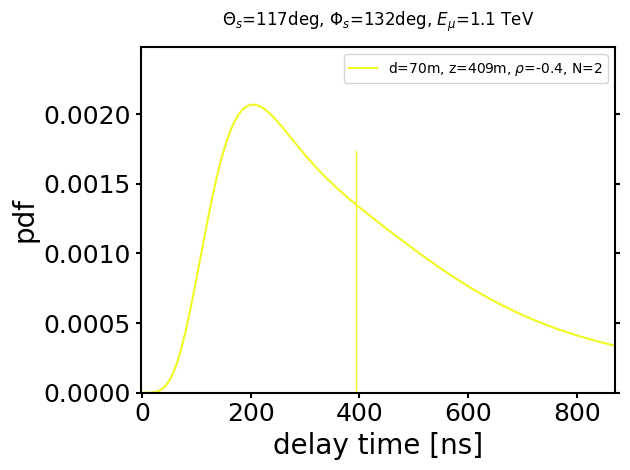

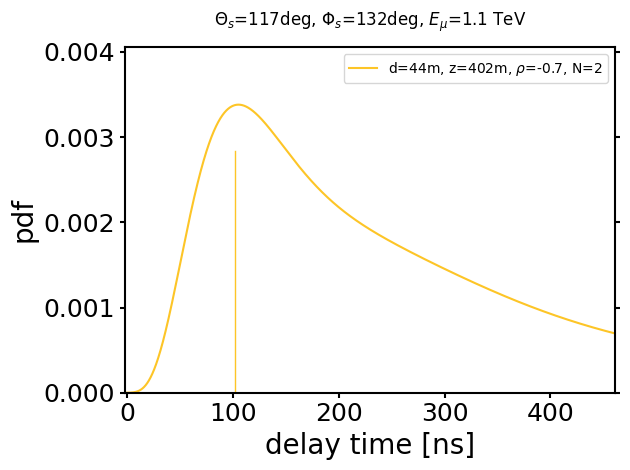

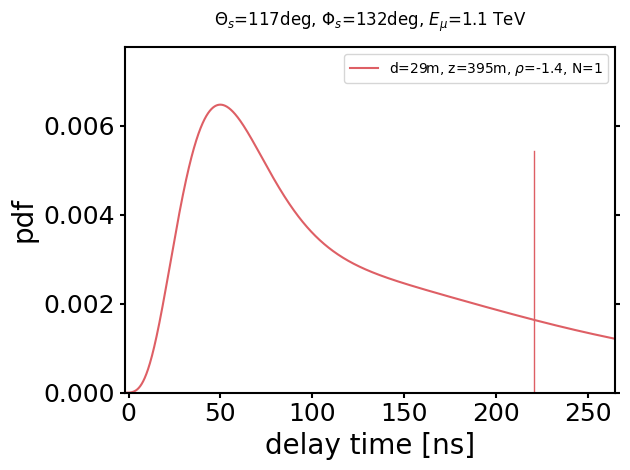

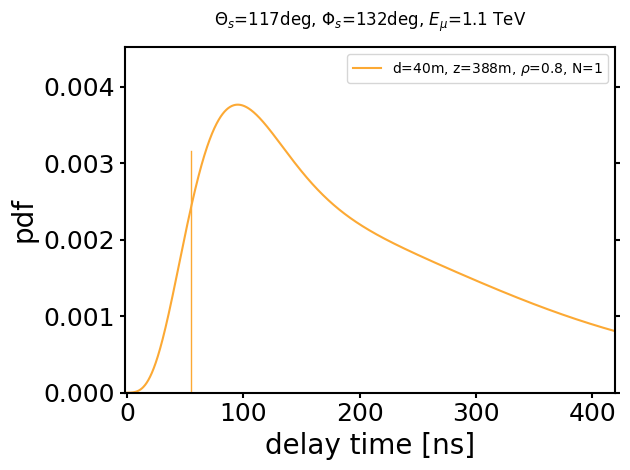

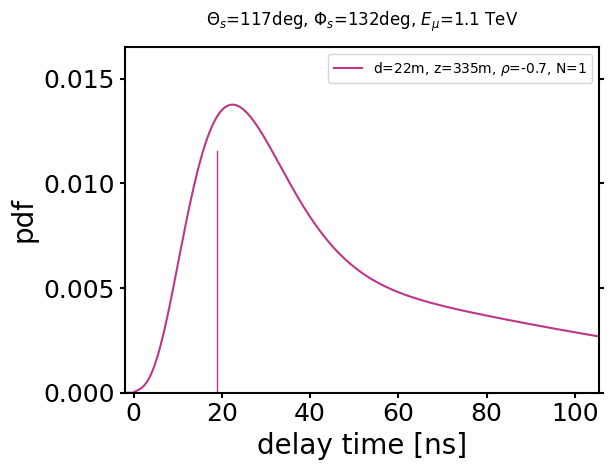

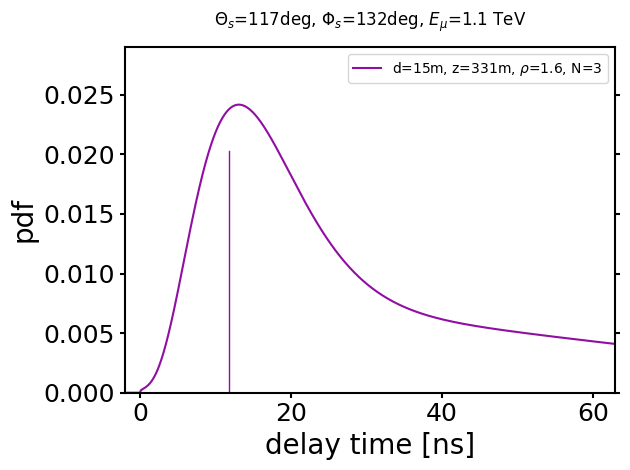

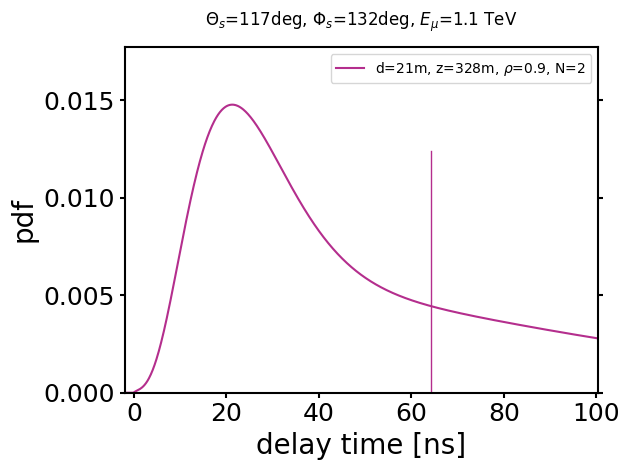

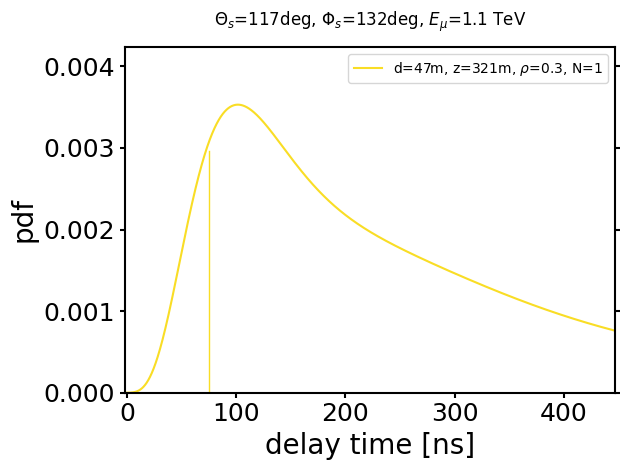

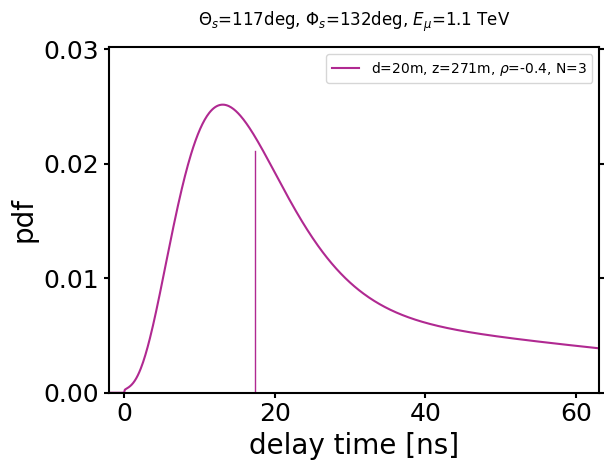

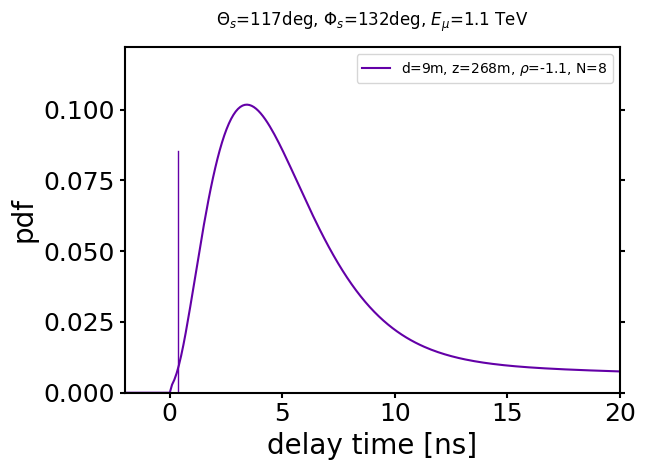

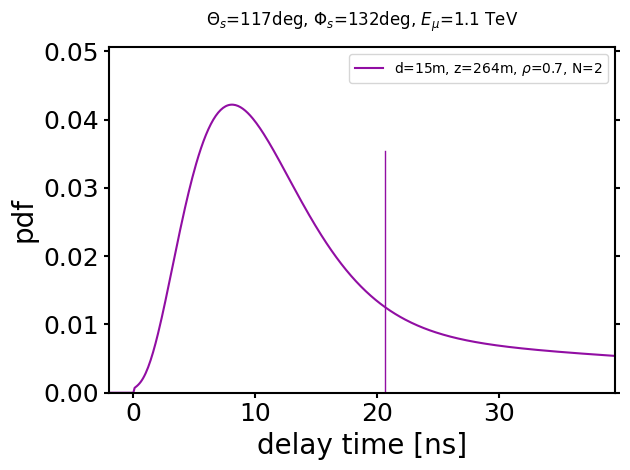

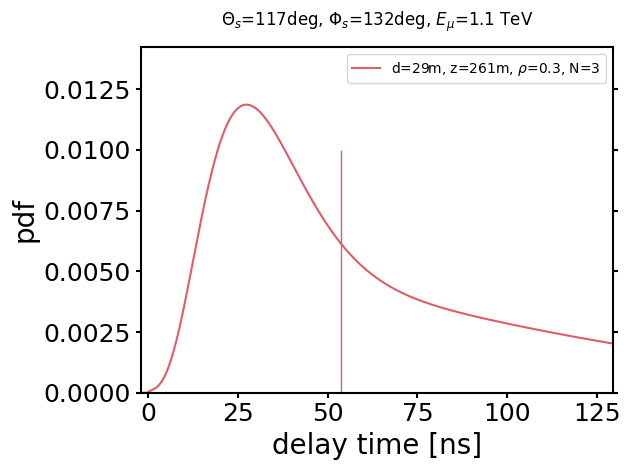

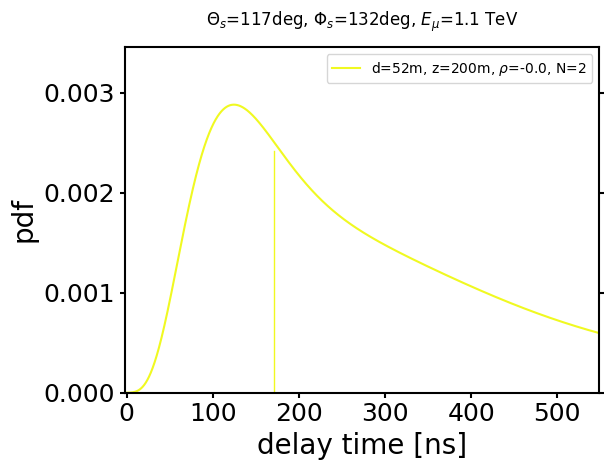

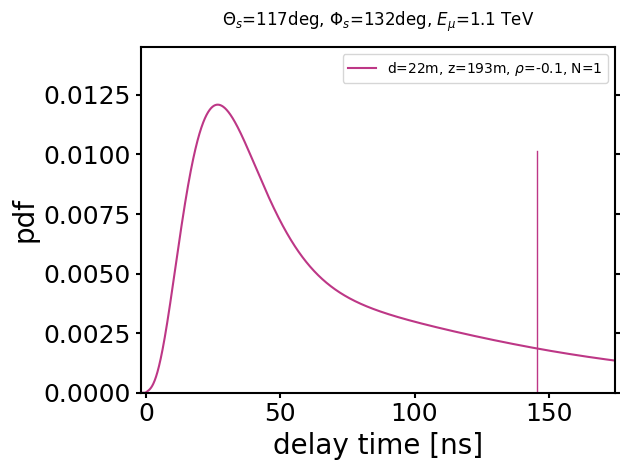

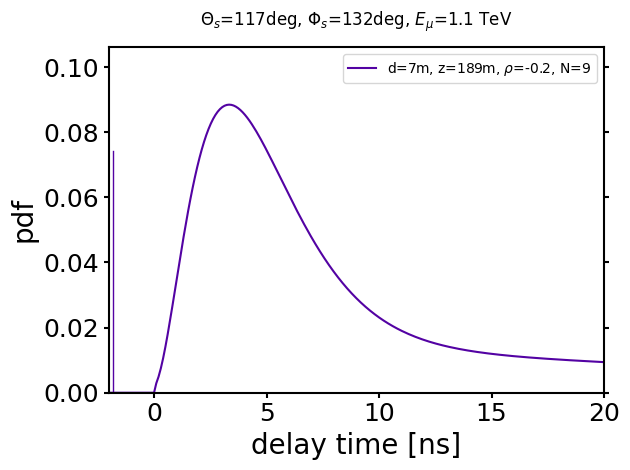

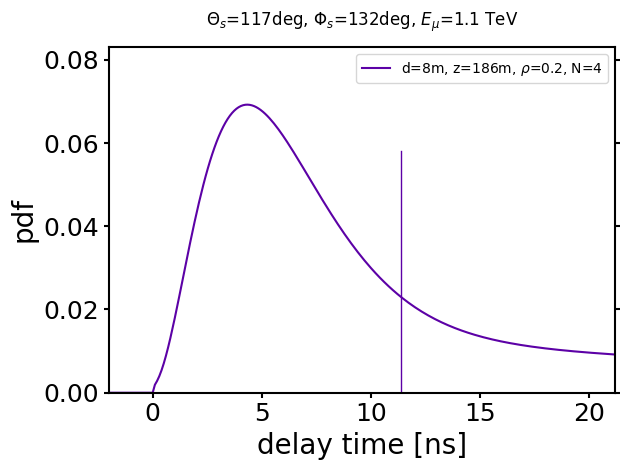

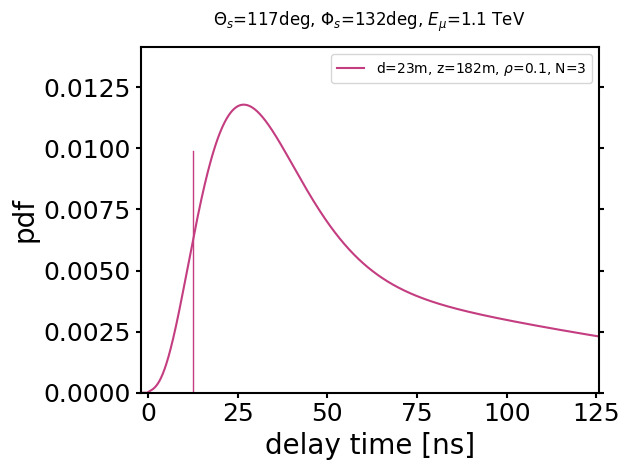

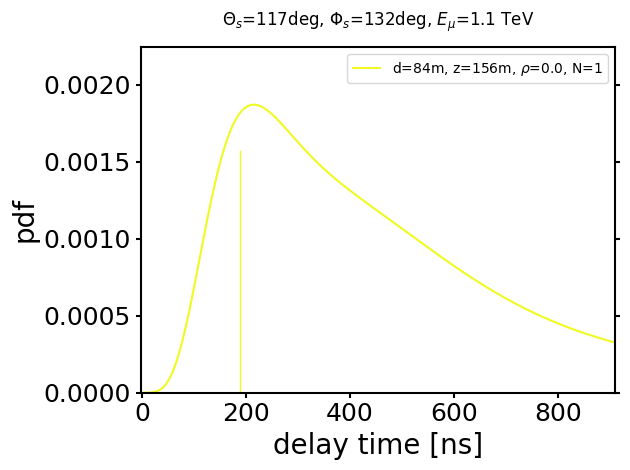

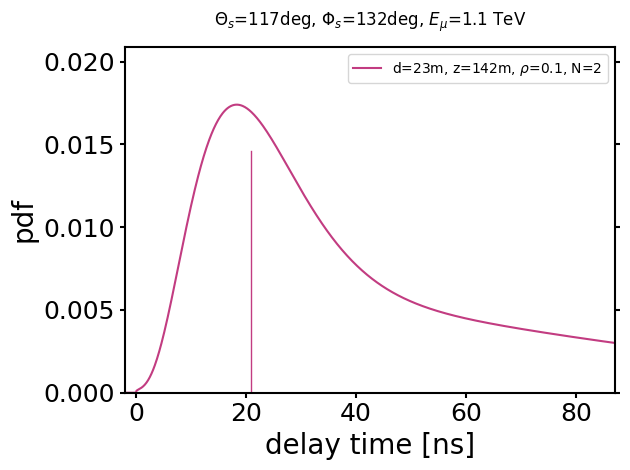

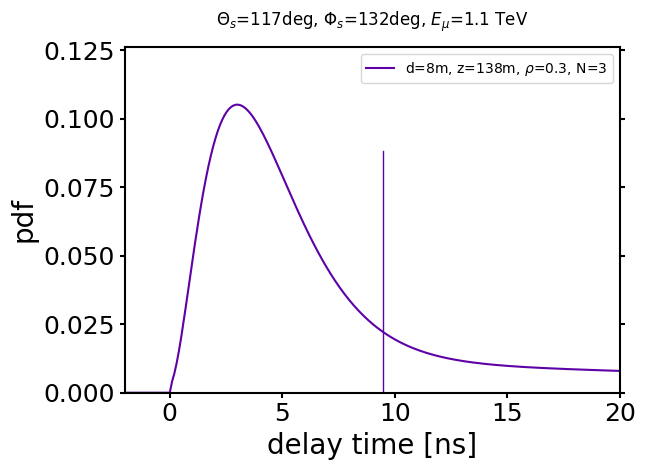

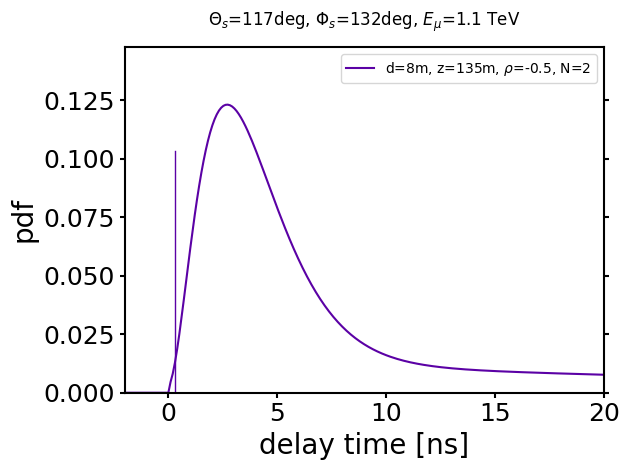

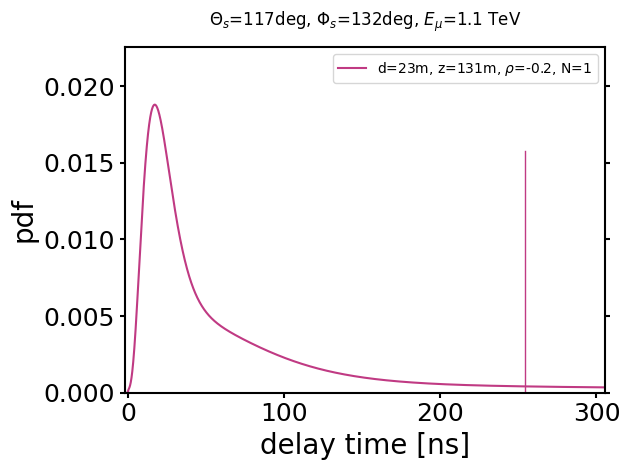

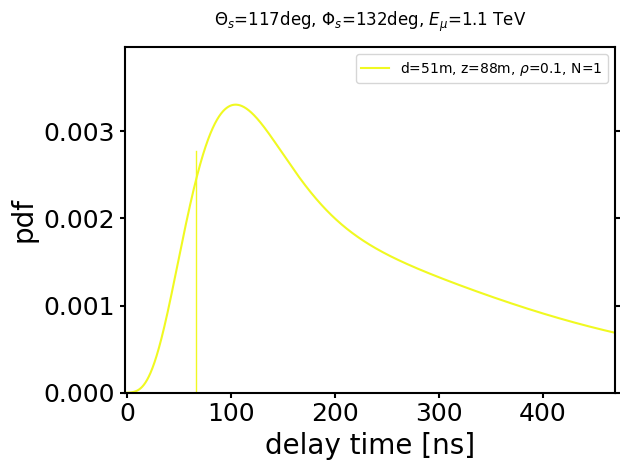

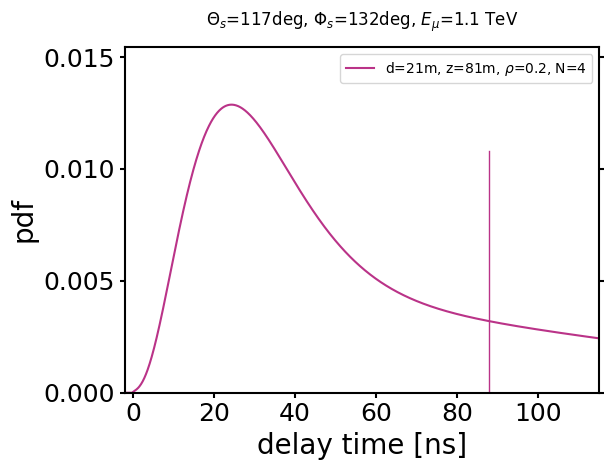

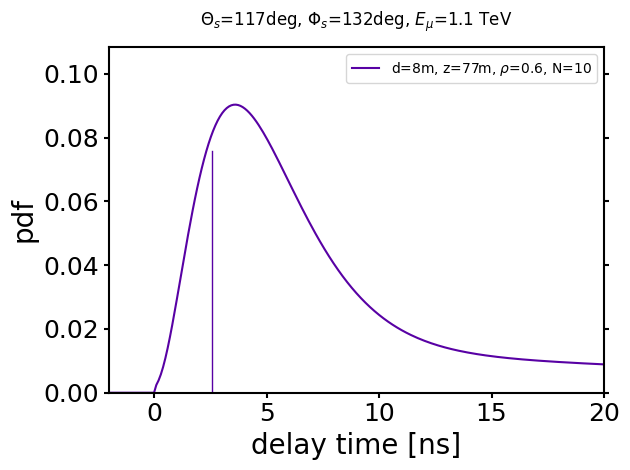

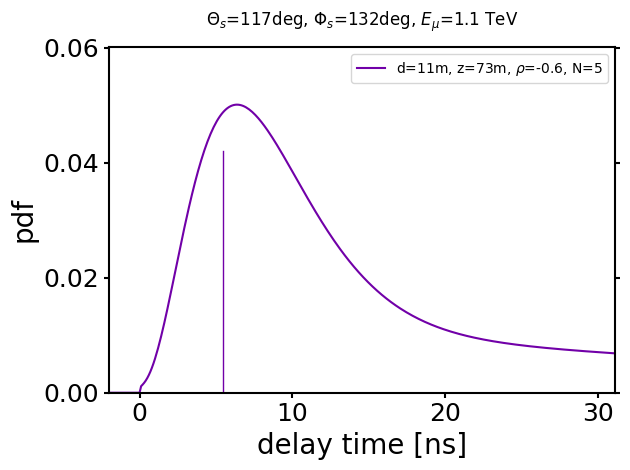

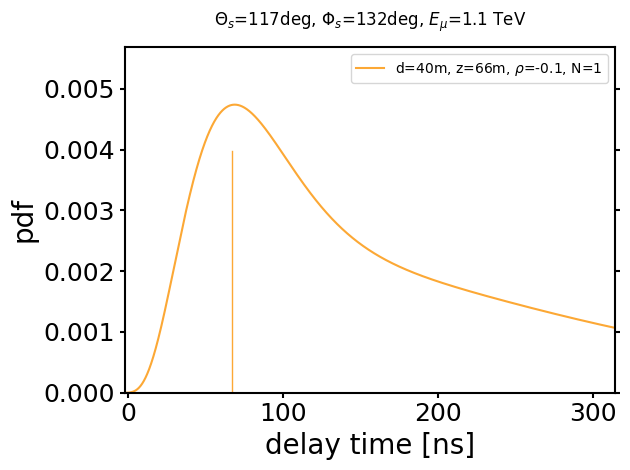

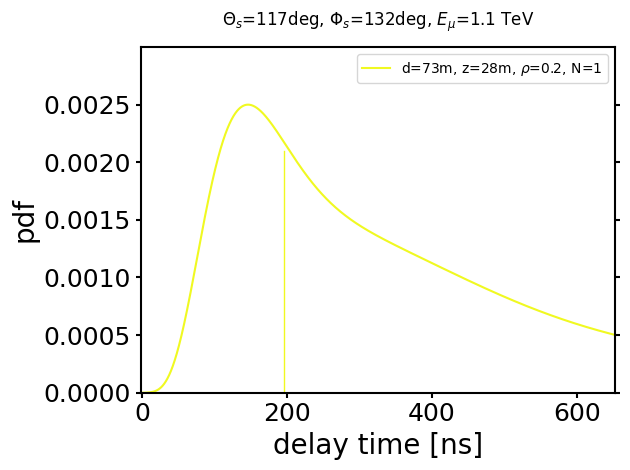

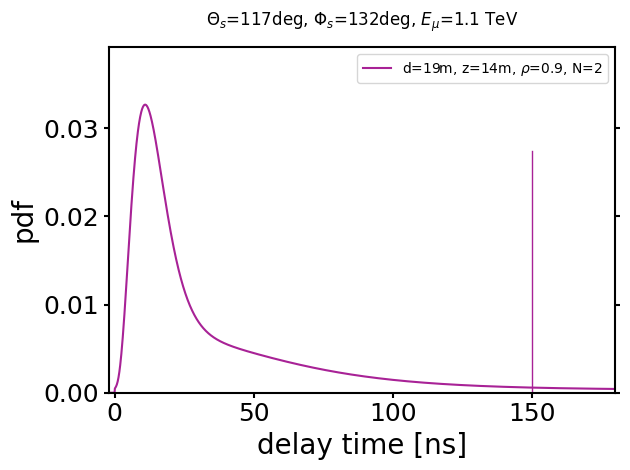

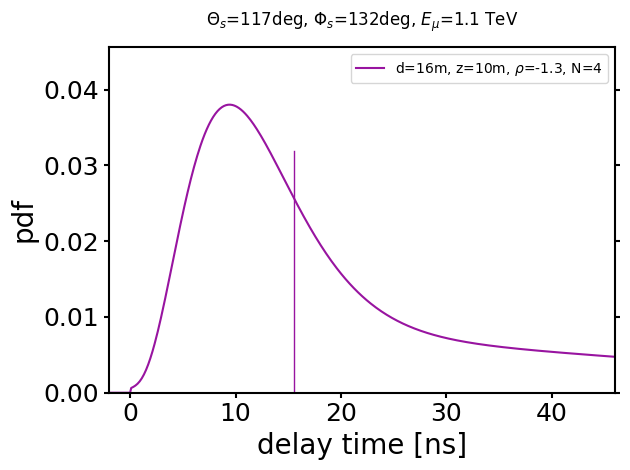

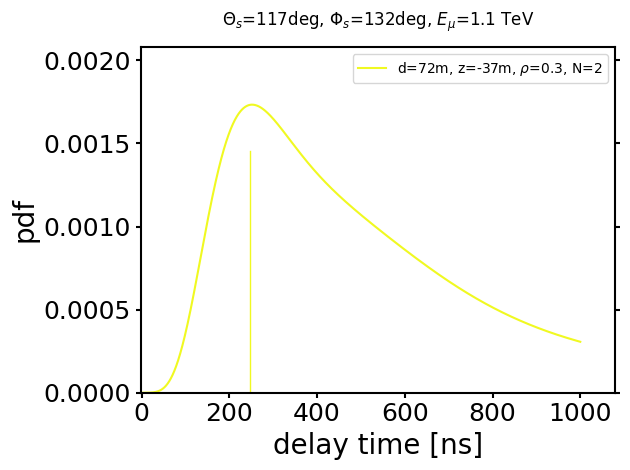

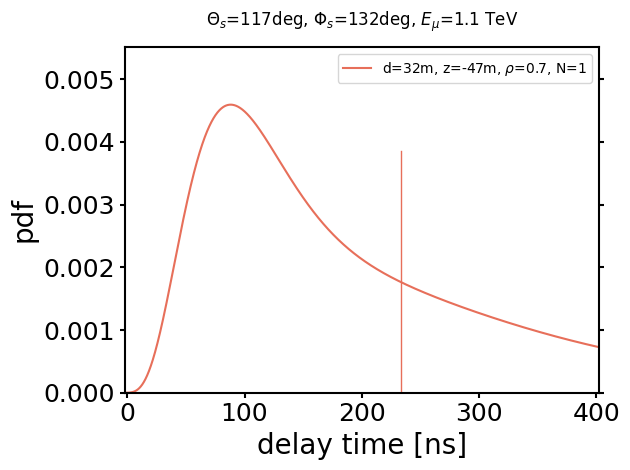

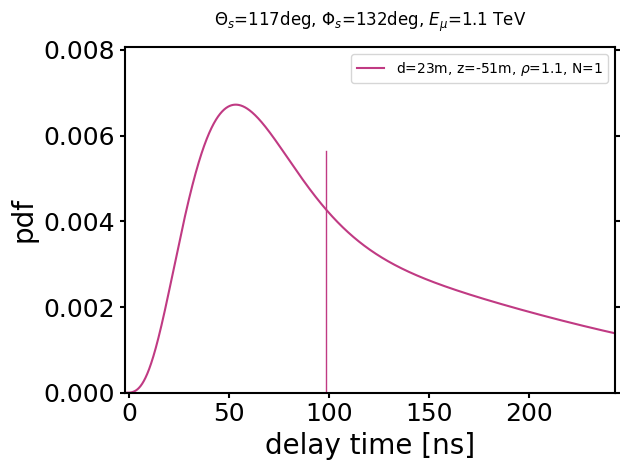

In [59]:
delay_times = dom_info_all['time'].values - (geo_time + meta['muon_time'])
xvals = np.linspace(-10, 1000, 10000)
qtots = dom_info['charge'].values

for i, yval in enumerate(yvals.T):
    if dists[i] > 100:
        continue
        
    fig, ax = plt.subplots()
    plt.plot(xvals, yval, color=cols[i], label=f'd={dists[i]:.0f}m, z={float(closest_approach_z[i]):.0f}m, $\\rho$={float(closest_approach_rho[i]):.1f}, N={qtots[i]:.0f}')
    
    
    plt.axvline(x=float(delay_times[i]), ymax=0.7, linewidth=1, color=cols[i])
    
    plot_args = {'xlim':[-2, np.max([20, 5 * mode[i, 1], float(delay_times[i])*1.2])],
                     'ylim':[0.0, 1.2 * np.amax(yval)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
    zenith = np.rad2deg(meta['muon_zenith'])
    azimuth = np.rad2deg(meta['muon_azimuth'])
    adjust_plot_1d(fig, ax, plot_args=plot_args)
    plt.title(f"$\\Theta_s$={zenith:.0f}deg, $\\Phi_s$={azimuth:.0f}deg, $E_\mu$={meta['muon_energy_at_detector']/1000:.1f} TeV", pad=15)
    plt.tight_layout()
    plt.show()

In [60]:
print(yvals.shape)

(10000, 40)


In [61]:
class I3SimHandlerFtr:
    def __init__(self, events_meta_file: str, 
                 events_pulses_file: str, 
                 geo_file: str) -> None:
        
        self.events_meta = pd.read_feather(events_meta_file)
        self.events_data = pd.read_feather(events_pulses_file)
        self.geo = pd.read_csv(geo_file)

    def get_event_data(self, event_index: int) -> np.ndarray:
        ev_idx = event_index
        event_meta = self.events_meta.iloc[ev_idx]
        event_data = (self.events_data.iloc[int(event_meta.idx_start): int(event_meta.idx_end + 1)]).copy(deep=True)
        return event_meta, event_data

    def get_per_dom_summary(self, event_index: int):
        meta, pulses = self.get_event_data(event_index)
        df_qtot = pulses[['sensor_id', 'charge']].groupby(by=['sensor_id'], as_index=False).sum()
        df_tmin = pulses[['sensor_id', 'time']].groupby(by=['sensor_id'], as_index=False).min()
        df = df_qtot.merge(self.geo.iloc[df_qtot['sensor_id']], on='sensor_id', how='outer')
        df['time'] = df_tmin['time'].values
        return df

In [62]:
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/detector_geometry.csv')

In [63]:
data = sim_handler.get_per_dom_summary(0)

In [64]:
print(data)

    sensor_id  charge       x       y       z     time
0      1436.0   0.975 -245.65 -190.49 -451.07  11191.0
1      1438.0   1.850 -245.65 -190.49 -484.99   9955.0
2      1439.0   1.900 -245.65 -190.49 -502.01   9887.0
3      1974.0   1.025 -324.39  -93.43 -418.99  10276.0
4      2036.0   0.875 -200.55  -74.03 -429.74  10153.0
5      2037.0   1.125 -200.55  -74.03 -446.76  10744.0
6      2039.0   0.725 -200.55  -74.03 -480.80  10150.0
7      2569.0   1.700 -279.53   23.17 -331.41  10908.0
8      2570.0   0.825 -279.53   23.17 -348.43  10760.0
9      2624.0   1.025 -156.23   43.37 -248.08  11195.0
10     2628.0   2.150 -156.23   43.37 -316.16  10741.0
11     2629.0   4.025 -156.23   43.37 -333.18  10592.0
12     2630.0   8.275 -156.23   43.37 -350.20  10535.0
13     2631.0   4.600 -156.23   43.37 -367.22  10529.0
14     2632.0   1.450 -156.23   43.37 -384.24  10826.0
15     2687.0   0.525  -32.96   62.44 -304.16  11231.0
16     3223.0   1.275 -111.51  159.98 -231.36  11605.0
17     328